# Volcanic Ash Tracking Model

Two Flow fields

1. Lagrangian - following the particle, non constant location
2. Eulerian - in a constant location, passing of the particle

“PUFF: A Lagrangian Trajectory Volcanic Ash Tracking Model” 


# Get meterological input data
1. data source Urban Emissions Info India Air quality forecast output

In [ ]:
import PseudoNetCDF as pnc
inpath = 'india_met_10days_wrfout.nc'
outpath = 'cf_india_met_10days_wrfout.nc'
infile = pnc.pncopen(inpath, addcf=True)
infile.save(outpath)

In [ ]:
import xarray as xr
import numpy as np


dataDIR = 'india_met_10days_wrfout.nc'
DS = xr.open_dataset(dataDIR)
da_u = DS.U

hr3_da_u=da_u[1::3]
np.save('u.npy', hr3_da_u) 
da_u=0
hr3_da_u=0


da_v = DS.V

hr3_da_v=da_v[1::3]
np.save('v.npy', hr3_da_v) 
da_v=0
hr3_da_v=0

da_w = DS.W

hr3_da_w=da_w[1::3]
np.save('w.npy', hr3_da_w) 
da_w=0
hr3_da_w=0

xlat=DS.XLAT
hr3_xlat=xlat[1::3]
np.save('xlat.npy', hr3_xlat) 

xlong=DS.XLONG
hr3_xlong=xlong[1::3]
np.save('xlong.npy', hr3_xlong) 


## check on grid extent and height values

In [ ]:
U = np.load('u_wind.npy')
U.shape

In [ ]:
xlong = np.load('xlat.npy')
xlong

In [ ]:
xlong = np.load('xlong.npy')
xlong

# Importing the requeried modules

In [1]:
#Code from http://publish.illinois.edu/pillsburydoughcat/puff-model/puff-model-supplementary-material/

import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap


## variables
from variables import Rnew
from variables import Rold
from variables import R_step1
from variables import R_step2
from variables import R_step3
from variables import R_step4
from variables import Active

## Intials
from initial import initial

## degree_conversion 
from degree_conversion import degree_to_dx

## dispersion 
from dispersionx import dispersionx
from dispersiony import dispersiony
from dispersionz import dispersionz

## settling
from settling import settling

## advection
from advectionx import advectionx
from advectiony import advectiony
from advectionz import advectionz

## Model parameters

In [2]:
import numpy as np
#parameters
 
num_particles = 1000
time = 5.0 #days
dt = 10.0 * 60.#minutes
time_steps = int(time * 24.0 * 3600. / dt) + 1
 
D_log = np.zeros((num_particles))
for i in range(0,num_particles):
    D_log[i] = np.random.normal(-5.0,2.5)

#diameter of the particle
D = 10. ** (D_log)

# horizontal dispersion coefficient 
K_h = 2.0 * (10. **4.)
# vertical dispersion coefficient
K_v = 10.

#initial location of the particles, i.e. the volcano location 
start_lat = 12.283729
start_lon = 93.861916

#the spread of the initial plume, in decimal degrees. 
sigma_lon = .01
sigma_lat = .01

#meterological paramters 
U = np.load('u_wind.npy')
V = np.load('v_wind.npy')
W = np.load('w_wind.npy')
 

alt_coor = np.linspace(0,40000,41)
lat_coor = np.linspace(3,40,161)
lon_coor = np.linspace(64.,101.,161)

## Model variables 

In [3]:
 
#particle #,  location of paritcles
Rnew = np.zeros((num_particles,3)) #lat,lon,alt
Rold = np.zeros((num_particles,3)) #lat,lon,alt
R_step1 = np.zeros((num_particles,3)) #lat,lon,alt
R_step2 = np.zeros((num_particles,3)) #lat,lon,alt
R_step3 = np.zeros((num_particles,3)) #lat,lon,alt
R_step4 = np.zeros((num_particles,3)) #lat,lon,alt
Active = np.ones((num_particles)) #lat,lon,alt

## Setting the initial condition

In [6]:
#[height,lat,lon]; [z,y,x]

R = np.zeros((num_particles,3))
 
def initial(sigma_lat,sigma_lon):
    for i in range(0,num_particles):
        R[i,0] = 15000.* np.random.uniform()
        R[i,1] = np.random.normal(start_lat,sigma_lat)
        R[i,2] = np.random.normal(start_lon,sigma_lon)
 
    return R

Rold = initial(sigma_lat,sigma_lon)
 
lon1 = 65.
lon2 = 105.
lat1 = -5.
lat2 = 40.

## Ploting 2d imagery of the location

Text(0.5,1,'Particle Trajectory')

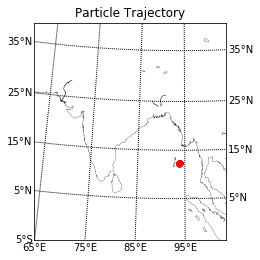

In [8]:
plt.figure(2)
m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2,
            projection='lcc',lon_0=start_lon,lat_0=start_lat,
            resolution ='l',area_thresh=1000.)
m.drawcoastlines(linewidth=0.25)
#m.drawcountries(linewidth=0.25)
m.drawparallels(np.arange(lat1,lat2,10),labels=[1,1,0,0])
m.drawmeridians(np.arange(lon1,lon2,10),labels=[0,0,0,1])
x, y = m(Rold[:,2],Rold[:,1])
m.scatter(x,y,s=20,marker='o',color='r',zorder=10)
plt.title('Particle Trajectory')

## Ploting 3d imagery of the location

Text(0.5,0.92,'Particle Trajectory')

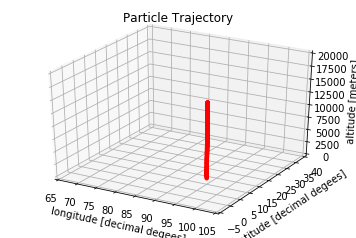

In [9]:
fig = plt.figure(1,facecolor = 'white')
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('longitude [decimal degees]')
ax.set_ylabel('latitude [decimal degees]')
ax.set_zlabel('altitude [meters]')
ax.set_zlim(0,20000)
ax.set_ylim(lat1,lat2)
ax.set_xlim(lon1,lon2)
ax.scatter(Rold[:,2],Rold[:,1],Rold[:,0],c='r',s=10)
ax.set_title('Particle Trajectory')

# simulate for single timestep

In [ ]:
## setting the time

In [10]:
t=1
t_index = int(float(t)/float(time_steps)*20.)
t_time_1 = float(t)/float(time_steps)*20.
t_time_2 = (float(t)+0.5)/float(time_steps)*20.
t_time_3 = (float(t)+0.5)/float(time_steps)*20.
t_time_4 = (float(t)+1.0)/float(time_steps)*20.   

dx_lat, dx_lon = degree_to_dx(R)

## Using RUNGA KUTTA method for advect, disperse, and settle a particle to a new location
used in temporal discretization for the approximate solutions of ordinary differential equations

In [11]:

R_step1[:,:] = 0.0
R_step2[:,:] = 0.0
R_step3[:,:] = 0.0
R_step4[:,:] = 0.0

### dispersion

In [12]:
dispz_temp = dispersionz(Active) * dt
dispy_temp = dispersiony(Active) * dt / dx_lat
dispx_temp = dispersionx(Active) * dt / dx_lon
R_step1[:,0] += dispz_temp
R_step2[:,0] += dispz_temp
R_step3[:,0] += dispz_temp
R_step4[:,0] += dispz_temp
R_step1[:,1] += dispy_temp
R_step2[:,1] += dispy_temp
R_step3[:,1] += dispy_temp
R_step4[:,1] += dispy_temp
R_step1[:,2] += dispx_temp
R_step2[:,2] += dispx_temp
R_step3[:,2] += dispx_temp
R_step4[:,2] += dispx_temp

### settling

In [13]:
R_step1[:,0] -= settling(D,Active) * dt
R_step2[:,0] -= settling(D,Active) * dt
R_step3[:,0] -= settling(D,Active) * dt
R_step4[:,0] -= settling(D,Active) * dt

### Advection

In [15]:
W=np.load('w_wind.npy')
#Rold,Active,t_index,t_time_1
T=0
R=Rold
alt_part = R[i,0]
lat_part = R[i,1]
lon_part = R[i,2]
a = int(R[i,0]/40000.*40.)
b = int((R[i,1]+90.)/180.*73.)
c = int(R[i,2]/360.*144.)

alt_coor = np.linspace(0,40000,41)
lat_coor = np.linspace(3,40,161)
lon_coor = np.linspace(64.,101.,161)


if a == 29:
    a_high = a
else:
    a_high = a+1

alt_low = alt_coor[a]
alt_high = alt_coor[a_high]
lat_down = lat_coor[b]
lat_up = lat_coor[b+1]
lon_left = lon_coor
lon_right = lon_coor

interp_x1 = (lon_part - lon_left) / (lon_right - lon_left) * (W[T,a,b,c+1] - W[T,a,b,c]) + W[T,a,b,c]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
alt_coor = np.linspace(0,29000,30)
lat_coor = np.linspace(-90.,90.,73)
lon_coor = np.linspace(0.,360.,144)

In [14]:
R_step1[:,0] += advectionz(Rold,Active,t_index,t_time_1) * dt
R_step1[:,1] += advectiony(Rold,Active,t_index,t_time_1) * dt / dx_lat
R_step1[:,2] += advectionx(Rold,Active,t_index,t_time_1) * dt / dx_lon
R_step2[:,0] += advectionz(Rold+R_step1/2.0,Active,t_index,t_time_2) * dt
R_step2[:,1] += advectiony(Rold+R_step1/2.0,Active,t_index,t_time_2) * dt / dx_lat
R_step2[:,2] += advectionx(Rold+R_step1/2.0,Active,t_index,t_time_2) * dt / dx_lon
R_step3[:,0] += advectionz(Rold+R_step2/2.0,Active,t_index,t_time_3) * dt
R_step3[:,1] += advectiony(Rold+R_step2/2.0,Active,t_index,t_time_3) * dt / dx_lat
R_step3[:,2] += advectionx(Rold+R_step2/2.0,Active,t_index,t_time_3) * dt / dx_lon
R_step4[:,0] += advectionz(Rold+R_step3,Active,t_index,t_time_4) * dt
R_step4[:,1] += advectiony(Rold+R_step3,Active,t_index,t_time_4) * dt / dx_lat
R_step4[:,2] += advectionx(Rold+R_step3,Active,t_index,t_time_4) * dt / dx_lon

Rnew =  Rold + R_step1/6.0 + R_step2/3.0 + R_step3/3.0 + R_step4/6.0   
Active, Rnew[:,0] = landed(Rnew[:,0],Active)

if t%(time_steps/50)==0:
    ax.scatter(Rnew[:,2],Rnew[:,1],Rnew[:,0],c='k',s=1,alpha=float(t)/float(time_steps-1)*0.5)
    plt.figure(2,facecolor='white')
    x, y = m(Rnew[:,2],Rnew[:,1])
    m.scatter(x,y,s=1,marker='o',color='k',alpha=float(t)/float(time_steps-1)*0.5,zorder=10)
    print(str(int(100.*float(t)/float(time_steps-1))) + '% done')
if t%(time_steps/10)==0:
    plt.figure(j)
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2,
        projection='lcc',lon_0=start_lon,lat_0=start_lat,
        resolution ='l',area_thresh=1000.)
    m.drawcoastlines(linewidth=0.25)
    m.drawcountries(linewidth=0.25)
    m.drawparallels(np.arange(lat1,lat2,10),labels=[1,1,0,0])
    m.drawmeridians(np.arange(lon1,lon2,10),labels=[0,0,0,1])
    x, y = m(start_lon,start_lat)
    m.scatter(x,y,s=20,marker='o',color='r',zorder=10)
    x, y = m(Rnew[:,2],Rnew[:,1])
    m.scatter(x,y,s=2,marker='o',color='k',zorder=10,alpha=0.5)
    plt.title('Plume after ' + str((j-2)*12) + ' hrs')

    fig = plt.figure(j+10,facecolor = 'white')
    axx = fig.add_subplot(111, projection='3d')
    axx.set_xlabel('longitude [decimal degees]')
    axx.set_ylabel('latitude [decimal degees]')
    axx.set_zlabel('altitude [meters]')
    axx.set_zlim(0,20000)
    axx.set_ylim(lat1,lat2)
    axx.set_xlim(lon1,lon2)
    axx.scatter(Rnew[:,2],Rnew[:,1],Rnew[:,0],c='k',s=1)
    axx.set_title('Plume after ' + str((j-2)*12) + ' hrs')
    j+=1

Rold = Rnew

/home/sunbird/Documents/april_2019/working_notes/NOgit_othernotes/Learning-Calculus-with-Python/p3_applications/puff-model/advectionz.py:30: RuntimeWarning: divide by zero encountered in true_divide
  interp_x1 = (lon_part - lon_left) / (lon_right - lon_left) * (W[T,a,b,c+1] - W[T,a,b,c]) + W[T,a,b,c]
/home/sunbird/Documents/april_2019/working_notes/NOgit_othernotes/Learning-Calculus-with-Python/p3_applications/puff-model/advectionz.py:31: RuntimeWarning: divide by zero encountered in true_divide
  interp_x2 = (lon_part - lon_left) / (lon_right - lon_left) * (W[T,a,b+1,c+1] - W[T,a,b+1,c]) + W[T,a,b+1,c]
/home/sunbird/Documents/april_2019/working_notes/NOgit_othernotes/Learning-Calculus-with-Python/p3_applications/puff-model/advectionz.py:32: RuntimeWarning: divide by zero encountered in true_divide
  interp_x3 = (lon_part - lon_left) / (lon_right - lon_left) * (W[T,a_high,b,c+1] - W[T,a_high,b,c]) + W[T,a_high,b,c]
/home/sunbird/Documents/april_2019/working_notes/NOgit_othernotes/Lear

ValueError: setting an array element with a sequence.

In [ ]:
W.shape